In [1]:
import sys
import pandas as pd
import numpy
sys.path.append('../scripts/')
from run_holdout_experiments import createReSTobject, preprocess
import seaborn as sns
from matplotlib import pyplot as plt
import scanpy as sc
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score as sscore
from sklearn.metrics import calinski_harabasz_score as chscore
import numpy as np
from time import sleep
import os
import warnings
warnings.filterwarnings('ignore')

/home/humble_local_25t/alexw/miniconda3/envs/ReST/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
pDir = '../../MIST_additional_holdout/data/'
data_names = os.listdir(pDir)
data_names.remove('spot_metadata.tsv')
data_names

['MouseAD',
 'Human_Glioblastoma',
 'MouseWT',
 'Human_Ovarian_Cancer',
 'Human_Prostate_Cancer_Adenocarcinoma_FFPE',
 'Human_Prostate_Cancer_Acinar_Cell_Carcinoma_FFPE',
 'Human_Invasive_Ductal_Carcinoma',
 'Human_Breast_Cancer_Ductal_Carcinoma_FFPE',
 'Melanoma',
 'Human_Colorectal_Cancer',
 'Human_Breast_Cancer_BAS1',
 'Prostate',
 'Human_Breast_Cancer_BAS2']

In [3]:
from tqdm import tqdm
# data_name = 'Human_Breast_Cancer_BAS1'
model_perf_dfs = []
for i, data_name in enumerate(tqdm(data_names)):    
    cluster_results = pd.read_csv(f"{pDir}{data_name}/cluster_results_all_methods_with_SpaGCN.csv", index_col=0)
    cluster_results.rename(columns={"refined_pred": "SpaGCN"}, inplace=True)
    
    try:
        adata = sc.read_visium(f"../../MIST_Visium_Tumors/{data_name}").obs.copy()
        inds = adata[['array_col', 'array_row']].apply(lambda x: 'x'.join(x.astype(str)), axis=1)
        STAGATE_res = pd.read_csv(f"STAGATE_mclust_13_output/{data_name}.csv", index_col=0)
        STAGATE_res.index = inds
    except:
        try:
             STAGATE_res = pd.read_csv(f"STAGATE_mclust_ST_output/{data_name}.csv", index_col=0)
        except:
            print(data_name)
            
    
    STAGATE_res = STAGATE_res.loc[cluster_results.index, :]
    cluster_results.insert(loc=0, column='STAGATE', value=STAGATE_res.STAGATE)

    methods = ['MIST', 'leiden', 'KMeans', 'hClust', 'BayesSpace instructed',
          'BayesSpace comparable', 'SpaGCN', 'STAGATE']

    raw_fn = os.path.abspath(f"{pDir}{data_name}/raw.csv")
    rd = createReSTobject(raw_fn)
    rd.adata = preprocess(rd.adata, hvg_prop=0.8)
    radata = rd.adata.copy()
    obs = pd.concat([radata.obs, cluster_results], axis=1)
    radata.obs = obs

    X_pca = radata.obsm['X_pca']
    sscores, sspatials = [], []
    for model in methods:
        if model == 'MIST':
            rmist = radata[radata.obs.MIST != 'isolated',:]
            x_pca = rmist.obsm['X_pca']
            coords = rmist.obs[['array_col', 'array_row']]
            labels = rmist.obs[model].tolist()
        else:
            x_pca = radata.obsm['X_pca']
            coords = radata.obs[['array_col', 'array_row']]
            labels = radata.obs[model].tolist()
        sscores.append(sscore(x_pca, labels, metric='correlation'))
        sspatials.append(sscore(coords, labels))

    model_perfs = pd.DataFrame({'model': methods,
                            'silhouette coefficient': sscores,
                           'silhouette spatial': sspatials})
    model_perfs['data_name'] = data_name
    model_perfs = model_perfs.sort_values('silhouette coefficient', ascending=False)
    model_perf_dfs.append(model_perfs)

model_perf_dfs = pd.concat(model_perf_dfs)
# # cluster_results.to_csv(f"{pDir}{data_name}/cluster_results_all_methods.csv")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:52<00:00, 36.34s/it]


In [5]:
model_perf_dfs.to_csv(f"SourceData_Fig2F_raw_cluster_silhouette_all_methods.csv")

In [5]:
res_dfs = []
for data_name in data_names:
    louv_fn =f'{pDir}/{data_name}/louvain_silhouette.csv'
    res = model_perf_dfs.loc[model_perf_dfs.data_name==data_name,:]
    louv_res = pd.read_csv(louv_fn, index_col=0)
    louv_res = louv_res.loc[louv_res.model == 'louvain']
    louv_res['data_name'] = data_name
    res['silhouette combined'] = res['silhouette coefficient'] + res['silhouette spatial']
    louv_res['silhouette combined'] = louv_res['silhouette coefficient'] + louv_res['silhouette spatial']
    res_dfs.append(res)
    res_dfs.append(louv_res)
res_dfs = pd.concat(res_dfs)

sil_df = res_dfs[['model', 'silhouette coefficient']]
spatial_sil_df = res_dfs[['model', 'silhouette spatial']]
combined_sil_df = res_dfs[['model', 'silhouette combined']]

sil_df.columns=['model', 'silhouette']
sil_df['feature'] = 'Transcriptome'

spatial_sil_df.columns=['model', 'silhouette']
spatial_sil_df['feature'] = 'Spatial'

combined_sil_df.columns=['model', 'silhouette']
combined_sil_df['feature'] = 'Combined'


sil_dfs = pd.concat([sil_df, spatial_sil_df, combined_sil_df])
sil_dfs.model.replace("BayesSpace instructed", "BayesSpace (I)", inplace=True)
sil_dfs.model.replace("BayesSpace comparable", "BayesSpace (C)", inplace=True)
sil_dfs.model.replace("hClust", "HClust", inplace=True)
sil_dfs.model.replace("leiden", "Leiden", inplace=True)
sil_dfs.model.replace("louvain", "Louvain", inplace=True)

In [6]:
from scipy.stats import ttest_rel

other_models = set(sil_dfs.model)
other_models.remove('MIST')
mist_spatial = sil_dfs.loc[(sil_dfs.model=='MIST') & (sil_dfs.feature=='Spatial'),
                           'silhouette'].to_numpy()
mist_transcriptome = sil_dfs.loc[(sil_dfs.model=='MIST') & (sil_dfs.feature=='Transcriptome'),
                                 'silhouette'].to_numpy()
mist_combined = sil_dfs.loc[(sil_dfs.model=='MIST') & (sil_dfs.feature=='Combined'),
                            'silhouette'].to_numpy()

summary_results = [pd.DataFrame(data=[['MIST', np.median(mist_spatial), 
                                       np.median(mist_transcriptome), 
                                       np.median(mist_combined),
                                       0,0,0,
                                       0,0,0,
                                       1, 1, 1]],
                        columns=['Model', 'Median SSC', 'Median TSC', 'Median CSC',
                                 'dSSC', 'dTSC','dCSC',
                                 'pct_dSCC', 'pct_dTSC','pct_dCSC',
                                 'P-value (SSC)', 'P-value (TSC)', 'P-value (CSC)'])]

for model in list(other_models):
    m_spatial = sil_dfs.loc[(sil_dfs.model==model) & (sil_dfs.feature=='Spatial'),'silhouette'].to_numpy()
    m_transcriptome = sil_dfs.loc[(sil_dfs.model==model) & (sil_dfs.feature=='Transcriptome'),
                                  'silhouette'].to_numpy()
    m_combined = sil_dfs.loc[(sil_dfs.model==model) & (sil_dfs.feature=='Combined'),
                                  'silhouette'].to_numpy()
    
    spatial_diff = np.median(m_spatial - mist_spatial)
    trans_diff = np.median(m_transcriptome - mist_transcriptome)
    comb_diff = np.median(m_combined - mist_combined)
    
    pct_spatial = np.absolute(100 * spatial_diff / np.median(mist_spatial))
    pct_trans = np.absolute(100 * trans_diff / np.median(mist_transcriptome))
    pct_comb = np.absolute(100 * comb_diff / np.median(mist_combined))
    ps = ttest_rel(m_spatial, mist_spatial)[1]
    pt = ttest_rel(m_transcriptome, mist_transcriptome)[1]
    pc = ttest_rel(m_combined, mist_combined)[1]
    
    summary_results.append(pd.DataFrame(data=[[model, 
                                               np.median(m_spatial), 
                                               np.median(m_transcriptome),
                                               np.median(m_combined),
                                   spatial_diff, trans_diff, comb_diff,
                                    pct_spatial, pct_trans, pct_comb,
                                    ps, pt, pc]],
                        columns=['Model', 'Median SSC', 'Median TSC','Median CSC',
                                 'dSSC', 'dTSC','dCSC', 'pct_dSSC', 'pct_dTSC','pct_dCSC',
                                 'P-value (SSC)', 'P-value (TSC)', 'P-value (CSC)']))
summary_results = pd.concat(summary_results)
summary_results.set_index("Model", inplace=True, drop=True)

In [7]:
method_orders = ['MIST', 'SpaGCN', 'STAGATE', 'BayesSpace (C)', 'BayesSpace (I)',
                     'HClust', 'Louvain', 'Leiden', 'KMeans']
summary_results.loc[method_orders, ['Median TSC', 'dTSC', 'pct_dTSC', 'P-value (TSC)']]

,Median TSC,dTSC,pct_dTSC,P-value (TSC)
Model,,,,
MIST,0.263163,0.000000,0.000000,1.000000
SpaGCN,0.081750,-0.146672,55.734080,0.021618
STAGATE,0.041282,-0.172152,65.416549,0.000750
BayesSpace (C),0.057069,-0.185356,70.434030,0.000809
BayesSpace (I),0.072738,-0.161846,61.500152,0.005563
HClust,0.116857,-0.070445,26.768414,0.076194
Louvain,0.120589,-0.086154,32.738004,0.023880
Leiden,0.095103,-0.110325,41.922546,0.021476
KMeans,0.185269,-0.066426,25.241536,0.428728


In [8]:
summary_results.loc[method_orders, 
                    ['Median SSC', 'dSSC', 'pct_dSSC', 'P-value (SSC)']]

,Median SSC,dSSC,pct_dSSC,P-value (SSC)
Model,,,,
MIST,0.259224,0.000000,NaN,1.000000
SpaGCN,0.085636,-0.148640,57.340490,0.063124
STAGATE,0.024588,-0.193057,74.475114,0.009536
BayesSpace (C),0.059839,-0.133510,51.503562,0.058325
BayesSpace (I),0.080970,-0.183766,70.890596,0.044285
HClust,-0.034805,-0.243058,93.763699,0.004920
Louvain,-0.049731,-0.260800,100.608012,0.000436
Leiden,-0.082502,-0.254753,98.275357,0.000261
KMeans,-0.025963,-0.282346,108.919824,0.005559


In [9]:
summary_results.loc[method_orders, ['Median CSC', 'dCSC', 'pct_dCSC', 'P-value (CSC)']]

,Median CSC,dCSC,pct_dCSC,P-value (CSC)
Model,,,,
MIST,0.476627,0.000000,0.000000,1.000000
SpaGCN,0.228641,-0.257140,53.950020,0.007033
STAGATE,0.057204,-0.347826,72.976621,0.000248
BayesSpace (C),0.083769,-0.395701,83.021019,0.001598
BayesSpace (I),0.132242,-0.321801,67.516235,0.003775
HClust,0.086580,-0.220183,46.195975,0.004480
Louvain,0.095434,-0.327602,68.733388,0.000157
Leiden,0.011370,-0.386112,81.009195,0.000147
KMeans,0.152012,-0.146487,30.734108,0.011755


In [10]:
summary_results.drop(columns="pct_dSCC", inplace=True)

['MIST', 'SpaGCN', 'KMeans', 'BayesSpace (I)', 'Louvain', 'HClust', 'BayesSpace (C)', 'STAGATE', 'Leiden']


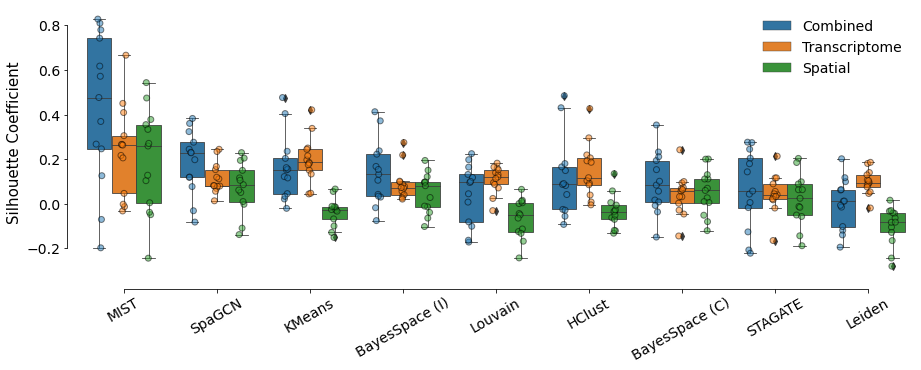

In [12]:
f = plt.figure(figsize=(15,5))


model_order = summary_results.sort_values("Median CSC", ascending=False).index.tolist()
print(model_order)
g = sns.boxplot(data=sil_dfs, x='model', y='silhouette',
                order=model_order,
                hue='feature', linewidth=0.8, hue_order=['Combined', 'Transcriptome', 'Spatial'])

sns.stripplot(data=sil_dfs, x='model', y='silhouette', hue='feature',
              order=model_order,
              dodge=True, size=6, c='pink', alpha=0.5, edgecolor='black', linewidth=1,
              hue_order=['Combined', 'Transcriptome', 'Spatial'])

h, l = g.get_legend_handles_labels()
plt.legend(h[:3], l[:3], fontsize=14, frameon=False)

sns.despine(offset=10, trim=True);
plt.tick_params(axis='both', labelsize=14);
plt.tick_params(axis='x', labelrotation=30);
plt.ylabel("Silhouette Coefficient", fontsize=15);
plt.xlabel("");

plt.savefig("../Figure2g-clustering-silhouttee-coefficient_with_combined.png",
            dpi=200, bbox_inches='tight')

In [16]:
res_dfs.to_excel("../SourceData-Figure2g-with-STAGATE.xlsx", sheet_name='Fig. 2g')